In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
import re,string,unicodedata

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, precision_recall_fscore_support
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import Constant

import random
random_state = 7

[nltk_data] Downloading package punkt to C:\Users\jathin
[nltk_data]     varma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\jathin
[nltk_data]     varma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_json("Sarcasm_Headlines_Dataset.json", lines = True)
data.head(10)

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0
7,https://www.huffingtonpost.com/entry/boxed-col...,"this ceo will send your kids to school, if you...",0
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
9,https://www.huffingtonpost.com/entry/fridays-m...,friday's morning email: inside trump's presser...,0


In [3]:
data.shape

(26709, 3)

In [4]:
#Checking for Null
data.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [5]:
print(f'sarcastic count -{data[data.is_sarcastic == 1].shape[0]}')
print(f'non sarcastic count - {data[data.is_sarcastic == 0].shape[0]}')

sarcastic count -11724
non sarcastic count - 14985


Data is not highly imbalanced.

In [6]:
huffington = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
onion = data[data['article_link'].str.contains('theonion.com')].shape[0]

In [7]:
print(huffington)
print(onion)

14985
11725


In [8]:
sarcastic_huffington = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
print(sarcastic_huffington)

0


This says that huffingtonpost.com has no sarcastic posts

In [9]:
sarcastic_onion = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
print(sarcastic_onion)

11724


Except for one post from theonion.com other all are sarcastic posts

In [10]:
# Headlines and labels from the data.
long_posts = list(data.loc[data['headline'].str.len() > 100, 'headline'].index)
random_long_posts = random.sample(long_posts, 5)
headlines = list(data.loc[random_long_posts, 'headline'])
print(f'Headline - {headlines}/n')

Headline - ['as global policy moves to expand digital rights, u.s faces crucial fight over equal access to the internet', "'breitbart' refusing to release names of mass shooting victims in order to prevent them from getting attention", 'bound, gagged joaquin castro horrified by what his identical twin brother might be doing out on dnc floor', "can california assemblyman/surfer travis allen ride a wave of voter discontent into the governor's office?", "hillary clinton: 'when i was a child, most special interest groups wouldn't even consider donating large sums of money to a woman'"]/n


In [11]:
data.drop('article_link', axis = 1, inplace = True)

In [12]:
# Pre-processing 
stop = stopwords.words('english')
lemmatizer = nltk.WordNetLemmatizer()

In [13]:
#Removing spaces
data['neat_headline'] = data['headline'].apply(lambda x: re.sub(' +',' ', x))

In [14]:
#Making headlines lower case
data['neat_headline'] = data['neat_headline'].apply(lambda x: x.lower())

In [15]:
#Removing punctuations
data['neat_headline'] = data['neat_headline'].apply(lambda x: re.sub('\[[^]]*\]', '', x))

In [16]:
#Removing special characters
data['neat_headline'] = data['neat_headline'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x))

In [17]:
#Removing stopwords and lemmatization
def remove_stopwords_and_lemmatization(n):
    final_text = []
    n = n.lower()
    n = nltk.word_tokenize(n)
    
    for word in n:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)

In [18]:
data['neat_headline'] = data['neat_headline'].apply(remove_stopwords_and_lemmatization)

In [19]:
#To get the length of each line 
data['length'] = data['neat_headline'].str.len()

print('Max_len: {}'.format(data['length'].max()))

Max_len: 227


In [20]:
print('Line with maximum length: {}'.format(data[data['length'] == data['length'].max()]['neat_headline'].values[0]))

Line with maximum length: maya angelou poet author civil right activist holy cow tony award nominated actress college professor magazine editor streetcar conductor really streetcar conductor wow calypso singer nightclub performer foreign journalist dead


In [21]:
#Number of words
data['words'] = data['neat_headline'].apply(lambda x: len(x.split(' ')))
print('Max_word_length: {}'.format(data['words'].max()))
print('Line with maximum number of words: {}'.format(data[data['words'] == data['words'].max()]['neat_headline'].values[0]))

Max_word_length: 30
Line with maximum number of words: maya angelou poet author civil right activist holy cow tony award nominated actress college professor magazine editor streetcar conductor really streetcar conductor wow calypso singer nightclub performer foreign journalist dead


In [22]:
#Train, tune and Test
#Parametres
max_features = 10000
maxlen = data['words'].max()
embedding_size = 200

#Applying Tokenizer
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['neat_headline']))

#Vocabulary size
wi = tokenizer.word_index
vocab_size = len(wi) + 1
print(f'Vocabulary_Size: {vocab_size}')

Vocabulary_Size: 21731


In [23]:
X = tokenizer.texts_to_sequences(data['neat_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

In [24]:
#glove word embeddings
glove_file = 'glove.6B.zip'
# glove embeddings zipfile
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [25]:
#word embeddings using embeddings file
Embedding_file = 'glove.6B.200d.txt'

embeddings = {}
for o in open(Embedding_file, encoding="utf8"):
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

In [26]:
# Getting the minimum number of words
# creating a embeddings matrix
num_words = min(max_features, vocab_size) + 1

embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state, shuffle = True)

print(f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'\nNumber of rows in test dataset: {x_test.shape[0]}')


Number of rows in training dataset: 18696

Number of rows in test dataset: 8013


In [28]:
opti = Adam(lr = 0.01)

model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), 
                    input_length = maxlen, trainable = False))

model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPooling1D())

model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = opti, metrics = ['accuracy'])

#callbacks
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)  
model_cp = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 2, min_lr=0.0005, verbose=1),

callbacks = [early_stop, model_cp, reduce_lr]

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 200)           2000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 256)           336896    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [29]:
#Fitting
batch_size = 100
epochs = 15

history = model.fit(x_train, y_train, epochs = epochs, 
              validation_split = 0.2, batch_size = batch_size, verbose = 1, callbacks = callbacks)

Epoch 1/15
149/150 [============================>.] - ETA: 0s - loss: 0.6080 - accuracy: 0.6687
Epoch 00001: val_loss improved from inf to 0.50239, saving model to sarcasm_detector.h5
150/150 [==============================] - 16s 106ms/step - loss: 0.6076 - accuracy: 0.6693 - val_loss: 0.5024 - val_accuracy: 0.7588
Epoch 2/15
149/150 [============================>.] - ETA: 0s - loss: 0.4976 - accuracy: 0.7726
Epoch 00002: val_loss improved from 0.50239 to 0.50208, saving model to sarcasm_detector.h5
150/150 [==============================] - 15s 97ms/step - loss: 0.4974 - accuracy: 0.7726 - val_loss: 0.5021 - val_accuracy: 0.7578
Epoch 3/15
149/150 [============================>.] - ETA: 0s - loss: 0.4295 - accuracy: 0.8083
Epoch 00003: val_loss improved from 0.50208 to 0.46284, saving model to sarcasm_detector.h5
150/150 [==============================] - 15s 101ms/step - loss: 0.4300 - accuracy: 0.8079 - val_loss: 0.4628 - val_accuracy: 0.7888
Epoch 4/15
150/150 [===================

In [30]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

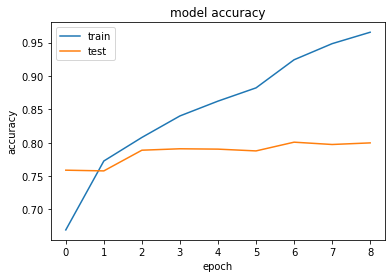

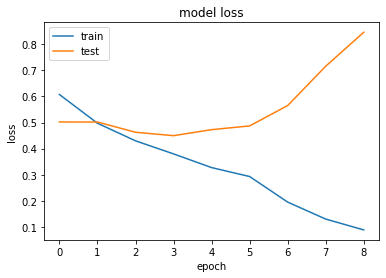

In [31]:
plot_history(history)

In [32]:
loss, accuracy = model.evaluate(x_test, y_test, verbose = 0)
print('Accuracy: {}'.format(round(accuracy * 100, 0)))

Accuracy: 80.0


In [33]:
y_pred = (model.predict(x_test) > 0.5).astype('int32')
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])
display(cm)

,Non-sarcastic,Sarcastic
Non-sarcastic,3837,740
Sarcastic,828,2608


In [34]:
#Accuracy, Precision, recall< f1 score
def calculate_results(y_true, y_pred):

    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"Accuracy": round(model_accuracy, 2),
                  "Precision": round(model_precision*100, 2),
                  "Recall": round(model_recall*100, 2),
                  "F1_score": round(model_f1*100,2)}
    return model_results

calculate_results(y_test, y_pred)

{'Accuracy': 80.43, 'Precision': 80.38, 'Recall': 80.43, 'F1_score': 80.4}